### Train a cats vs dogs classifier

In [1]:
import os
import glob
import time
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
# the pretrained net we're using
from torchvision.models import efficientnet_b0

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# globals
BATCH_SIZE = 32
EPOCHS = 16

NUM_WORKERS = 4

# size of the image we're working on
IMAGE_SIDE = 224

DIR_TRAIN = "./train_cats_dogs/"

In [3]:
imgs = glob.glob(DIR_TRAIN + "*.jpg")

# have a look at some images names
print(imgs[:5])

['./train_cats_dogs/dog.1564.jpg', './train_cats_dogs/dog.5155.jpg', './train_cats_dogs/dog.5943.jpg', './train_cats_dogs/dog.6978.jpg', './train_cats_dogs/dog.3523.jpg']


In [4]:
print(f"Number of images: {len(imgs)}")

Number of images: 25000


In [5]:
# here we codify labels

labels_codes = {"cat": 0, "dog": 1}

In [6]:
# I'm using mean and std for ImageNet
MEANS = [0.485, 0.456, 0.406]
STDS = [0.229, 0.224, 0.225]

def get_train_transform():
    return T.Compose(
        [
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(25),
            T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
            T.RandomCrop(IMAGE_SIDE),
            T.ToTensor(),
            T.Normalize(mean=MEANS, std=STDS),
        ]
    )

# val transforms doesn't make augmentation: we want to validate every time
# on the same images
def get_val_transform():
    return T.Compose(
        [T.ToTensor(), 
         T.Normalize(mean=MEANS, std=STDS)]
    )

In [7]:
class CatDogDataset(Dataset):
    def __init__(self, imgs, labels_codes, mode="train", transforms=None):
        super().__init__()
        self.imgs = imgs
        self.labels_codes = labels_codes
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.imgs[idx]

        img = Image.open(image_name)
        # OK for EfficientNet B0
        # if scaling to another EffNet change the size here!
        img = img.resize((IMAGE_SIDE, IMAGE_SIDE))

        if self.mode == "train" or self.mode == "val":

            # Preparing class label
            # cat or dog?
            # remove the dir
            image_name = image_name.split("/")[-1]
            # get the first part of the name
            image_type = image_name.split(".")[0]
            label = self.labels_codes[image_type]
            label = torch.tensor(label, dtype=torch.float32)

            # Apply Transforms on image
            img = self.transforms(img)

            return img, label

        elif self.mode == "test":

            # Apply Transforms on image
            img = self.transforms(img)

            return img

    def __len__(self):
        return len(self.imgs)

In [8]:
train_imgs, val_imgs = train_test_split(imgs, test_size=0.25)

In [9]:
# datasets
train_dataset = CatDogDataset(
    train_imgs, labels_codes, mode="train", transforms=get_train_transform()
)
val_dataset = CatDogDataset(
    val_imgs, labels_codes, mode="val", transforms=get_val_transform()
)

# data loaders
train_data_loader = DataLoader(
    dataset=train_dataset, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=True
)

val_data_loader = DataLoader(
    dataset=val_dataset, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=False
)

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
def accuracy(preds, trues):
    # as threshold we take the default
    THR = 0.5

    # Converting preds to 0 or 1
    preds = [1 if preds[i] >= THR else 0 for i in range(len(preds))]

    # Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]

    # Summing over all correct predictions
    acc = np.sum(acc) / len(preds)

    return acc * 100.

In [12]:
def train_one_epoch(train_data_loader):

    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    for images, labels in tqdm(train_data_loader):

        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape(
            (labels.shape[0], 1)
        )  # [N, 1] - to match with preds shape

        # Reseting Gradients
        optimizer.zero_grad()

        # Forward
        preds = model(images)

        # Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        # Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

        # Backward
        _loss.backward()
        optimizer.step()

    # Overall Epoch Results 
    total_time = time.time() - start_time

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    # TODO: improve this one
    epoch_acc = np.mean(epoch_acc)

    # Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)

    return epoch_loss, epoch_acc, total_time

In [13]:
def val_one_epoch(val_data_loader, best_val_acc):

    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    for images, labels in val_data_loader:

        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape(
            (labels.shape[0], 1)
        )  # [N, 1] - to match with preds shape

        # Forward
        preds = model(images)

        # Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        # Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

    # Overall Epoch Results
    total_time = time.time() - start_time

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    # Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "effb0_best.pth")

    return epoch_loss, epoch_acc, total_time, best_val_acc

In [14]:
model = efficientnet_b0(pretrained=True)

# Modifying Head, adding final classifier
# this one depends on the Net architecture. See docs

model.classifier[1] = nn.Sequential(nn.Linear(1280, 1, bias=True), nn.Sigmoid())

In [15]:
# Optimizer
# LR is 1/10 of the default. Is it the best?
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
# (LS): check, I don't think it is used
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss": [], "accuracy": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "time": []}

# Loading model to device
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

### Training Loop

In [16]:
best_val_acc = 0

for epoch in range(EPOCHS):
    # Training
    loss, acc, _time = train_one_epoch(train_data_loader)

    print()
    print(
        f"Training: Epoch {epoch}, Loss : {round(loss, 4)} Acc : {round(acc, 2)}, Time : {round(_time, 1)}"
    )

    # Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)

    print()
    print(
        f"Validation: Epoch {epoch}, Loss : {round(loss, 4)} Acc : {round(acc, 2)}, Time : {round(_time, 1)}"
    )

100%|██████████| 586/586 [01:15<00:00,  7.76it/s]


Training: Epoch 0, Loss : 0.1065 Acc : 96.48, Time : 75.5



Validation: Epoch 0, Loss : 0.0392 Acc : 98.72, Time : 12.8


100%|██████████| 586/586 [01:14<00:00,  7.82it/s]


Training: Epoch 1, Loss : 0.0364 Acc : 98.65, Time : 75.0



Validation: Epoch 1, Loss : 0.0333 Acc : 98.84, Time : 12.8


100%|██████████| 586/586 [01:14<00:00,  7.82it/s]


Training: Epoch 2, Loss : 0.0227 Acc : 99.23, Time : 75.0



Validation: Epoch 2, Loss : 0.0349 Acc : 98.71, Time : 12.8


100%|██████████| 586/586 [01:14<00:00,  7.81it/s]


Training: Epoch 3, Loss : 0.0186 Acc : 99.39, Time : 75.0



Validation: Epoch 3, Loss : 0.0327 Acc : 98.88, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 4, Loss : 0.0155 Acc : 99.53, Time : 75.0



Validation: Epoch 4, Loss : 0.0274 Acc : 99.03, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.80it/s]


Training: Epoch 5, Loss : 0.012 Acc : 99.63, Time : 75.1



Validation: Epoch 5, Loss : 0.025 Acc : 99.04, Time : 13.0


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 6, Loss : 0.0118 Acc : 99.64, Time : 75.1



Validation: Epoch 6, Loss : 0.027 Acc : 98.98, Time : 12.9


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 7, Loss : 0.01 Acc : 99.67, Time : 75.1



Validation: Epoch 7, Loss : 0.0373 Acc : 98.87, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 8, Loss : 0.0077 Acc : 99.73, Time : 75.1



Validation: Epoch 8, Loss : 0.0324 Acc : 98.95, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 9, Loss : 0.0064 Acc : 99.8, Time : 75.0



Validation: Epoch 9, Loss : 0.037 Acc : 98.77, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 10, Loss : 0.0079 Acc : 99.72, Time : 75.0



Validation: Epoch 10, Loss : 0.0415 Acc : 98.71, Time : 12.9


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 11, Loss : 0.006 Acc : 99.79, Time : 75.1



Validation: Epoch 11, Loss : 0.0365 Acc : 98.95, Time : 12.9


100%|██████████| 586/586 [01:15<00:00,  7.81it/s]


Training: Epoch 12, Loss : 0.0081 Acc : 99.75, Time : 75.0



Validation: Epoch 12, Loss : 0.034 Acc : 98.95, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.79it/s]


Training: Epoch 13, Loss : 0.0097 Acc : 99.67, Time : 75.2



Validation: Epoch 13, Loss : 0.0271 Acc : 99.15, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.80it/s]


Training: Epoch 14, Loss : 0.0052 Acc : 99.81, Time : 75.1



Validation: Epoch 14, Loss : 0.0286 Acc : 99.11, Time : 12.8


100%|██████████| 586/586 [01:15<00:00,  7.80it/s]


Training: Epoch 15, Loss : 0.0058 Acc : 99.84, Time : 75.1



Validation: Epoch 15, Loss : 0.034 Acc : 98.98, Time : 12.8


#### Plotting training and validation history

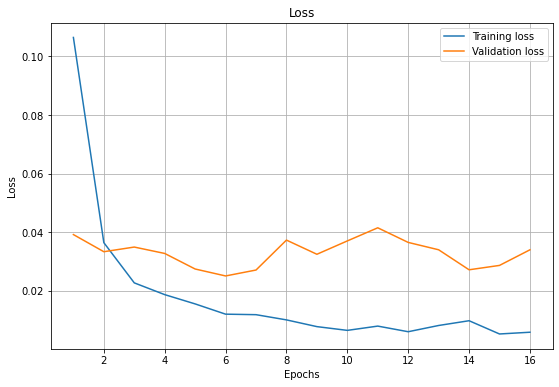

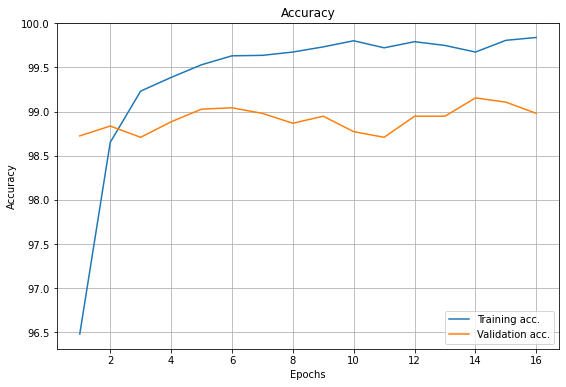

In [17]:
vet_epochs = np.arange(1, EPOCHS+1, 1)

# Loss
plt.figure(figsize=(9, 6))
plt.title("Loss")
plt.plot(vet_epochs, train_logs["loss"], label="Training loss")
plt.plot(vet_epochs, val_logs["loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(9, 6))
plt.title("Accuracy")
plt.plot(vet_epochs, train_logs["accuracy"], label="Training acc.")
plt.plot(vet_epochs, val_logs["accuracy"], label="Validation acc.")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()